In [87]:
import numpy as np
import pandas as pd
import math
import sys, os
import mplcyberpunk
import matplotlib.pyplot as plt
from matplotlib.colors import hex2color, to_hex
import matplotlib.colors as mc
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, cohen_kappa_score, confusion_matrix, ConfusionMatrixDisplay

import xgboost as xgb

In [2]:
train_time = 1 * 60 * 60
objective = 'xgbhandregressor'

In [3]:
sys.path.append(os.path.realpath('..'))

In [4]:
train_df = pd.read_csv(r"..\data\train.csv", index_col=0)
test_df = pd.read_csv(r"..\data\test.csv", index_col=0)
sample_sub = pd.read_csv(r"..\data\sample_submission.csv", index_col=0)

In [5]:
features = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']
target = ['quality']

In [6]:
train_df[features] = train_df[features].apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())))
test_df[features] = test_df[features].apply(lambda iterator: ((iterator.max() - iterator)/(iterator.max() - iterator.min())))

In [7]:
scaler = MinMaxScaler().fit(train_df[features])
X = scaler.transform(train_df[features])
X_test = scaler.transform(test_df[features])

scaler = MinMaxScaler().fit(train_df[target])
Y = scaler.transform(train_df[target])

In [8]:
#shrink for regressor
print(f'Before: {train_df[target[0]].unique()}')
train_df[target[0]] = train_df[target[0]] - np.min(train_df[target[0]].unique())
print(f'After:{train_df[target[0]].unique()}')

Before: [6 7 5 4 8 3]
After:[3 4 2 1 5 0]


# Rendering

In [9]:
plt.style.use("cyberpunk")

def render_xgb_features(model):
    histplot_hyperparams = {
            'alpha':0.4,
            #'stat':'percent',
            #'bins':100
            #'kde':True,
        }

    n_cols = 1
    n_rows = 1
    cell_with_dim = 20
    cell_height_dim = 5

    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))

    fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
    sns.barplot(fi_df.T.reset_index(), x='index', y=0,ax=ax, label=features, **histplot_hyperparams)
    #sns.histplot(train_df[target], ax=ax, **histplot_hyperparams)

    mplcyberpunk.make_lines_glow(ax)
    plt.show()

In [117]:
from itertools import islice, cycle
from cycler import cycler

plt.style.use("cyberpunk")

mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'] = cycler('color', ['#08F7FE', '#FE53BB', '#F5D300', '#00ff41', 'r', '#fe00fe', '#FF5733'])

def add_secondary_plot(df, column, target_column, ax, n_bins, color=3, show_yticks=False, marker="."):
    secondary_ax = ax.twinx()
    bins = pd.cut(df[column], bins=n_bins)
    bins = pd.IntervalIndex(bins)
    bins = (bins.left + bins.right) / 2
    target = df.groupby(bins)[target_column].mean()
    target.plot(
        ax=secondary_ax, linestyle='',
        marker=marker, color=color, label=f"Mean '{target_column}'"
    )
    secondary_ax.grid(visible=False)
    
    if not show_yticks:
        secondary_ax.get_yaxis().set_ticks([])
        
    return secondary_ax

def render_feature_distros(train_df, test_df, features=[], labels=[], n_bins=50, n_cols=4, pad=2, h_pad=4, w_pad=None, boarders=None):
    histplot_hyperparams = {
        'kde':True,
        'alpha':0.4,
        'stat':'percent',
        'bins':n_bins
    }
    markers = ['.', '+', 'x', '1', '2']
    
    n_rows = math.ceil(len(features) / n_cols)
    cell_with_dim = 4
    cell_height_dim = 3
    
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * cell_with_dim, n_rows * cell_height_dim))
    plt.tight_layout(pad=pad, h_pad=h_pad, w_pad=w_pad, rect=None)
    
    # delete exess subplots
    for a in ax[n_rows - 1, int(((n_rows - (len(features) / n_cols)) * n_cols*-1)):]:
        a.axis('off')
        
    leg_handles = []
    leg_labels = []
    
    axs = []
    
    hc = ['r', 'y', 'g']
    th = [0, 0.5, 1]

    cdict = NonLinCdict(th, hc)
    colormap = mc.LinearSegmentedColormap('test', cdict)
 

    for i, feature in enumerate(features):
        row = math.ceil(i / n_cols) - 1
        col = (i % n_cols)
        
        color_cycle = islice(mplcyberpunk.cyberpunk_stylesheets['cyberpunk']['axes.prop_cycle'], 0, None)
        
        sns.histplot(train_df[feature], label='Train X', ax=ax[row, col], color=next(color_cycle)['color'], **histplot_hyperparams)
        sns.histplot(test_df[feature], label='Test X', ax=ax[row, col],color=next(color_cycle)['color'], **histplot_hyperparams)
        ax[row, col].set_title(f'{feature} Distribution')
        
        if boarders is not None:
            c = to_hex(list(colormap(boarders[feature][0])))
            ax[row, col].spines['bottom'].set_color(c)
            ax[row, col].spines['bottom'].set_linewidth(1)
            ax[row, col].spines['top'].set_color(c)
            ax[row, col].spines['top'].set_linewidth(1)
            ax[row, col].spines['left'].set_color(c)
            ax[row, col].spines['left'].set_linewidth(1)
            ax[row, col].spines['right'].set_color(c)
            ax[row, col].spines['right'].set_linewidth(1)
            #ax[row, col].patch.set_linewidth('1')  
        
        mplcyberpunk.make_lines_glow(ax[row, col])
        axs.append(ax[row, col].get_legend_handles_labels())

        for j, label in enumerate(labels):
            sub_ax = add_secondary_plot(train_df, feature, label, ax[row, col], n_bins, color=next(color_cycle)['color'], marker=markers[j])
            axs.append(sub_ax.get_legend_handles_labels())
        
    for axis in axs:
        if axis[1][0] not in leg_labels:
            leg_labels.extend(axis[1])
            leg_handles.extend(axis[0])
        
    fig.legend(leg_handles, leg_labels, loc='upper center', bbox_to_anchor=(0.5, 1.04), fontsize=14, ncol=len(features) + 2)

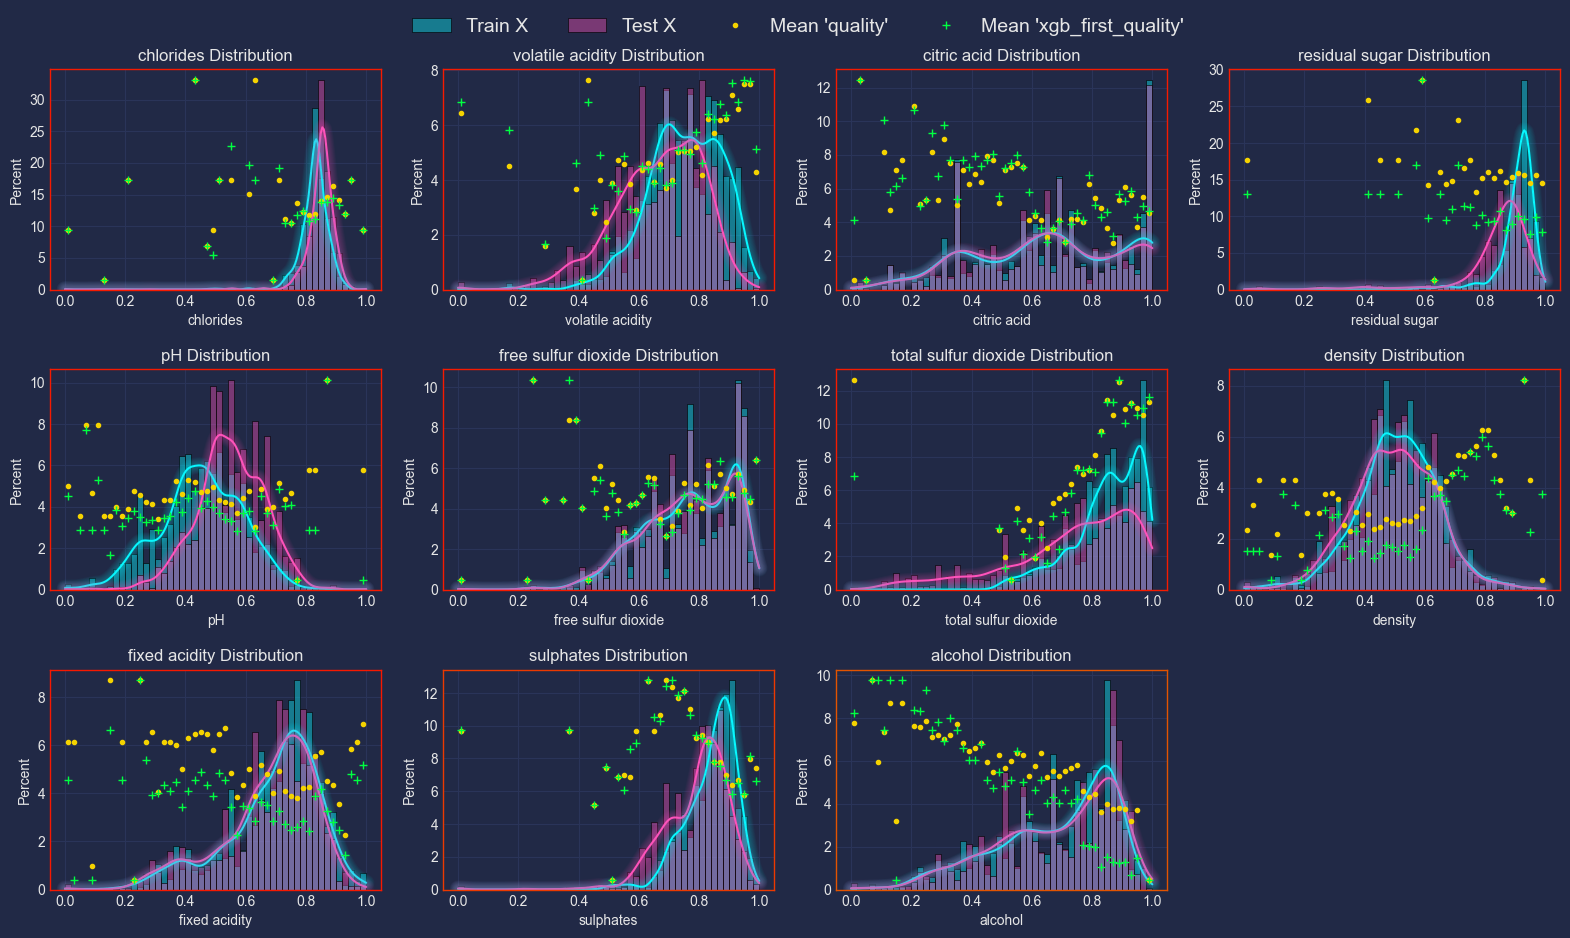

In [118]:
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0], f'xgb_first_{target[0]}'], boarders=fi_df.to_dict())

In [11]:
def NonLinCdict(steps, hexcol_array):
    cdict = {'red': (), 'green': (), 'blue': ()}
    for s, hexcol in zip(steps, hexcol_array):
        rgb = hex2color(hexcol)
        cdict['red'] = cdict['red'] + ((s, rgb[0], rgb[0]),)
        cdict['green'] = cdict['green'] + ((s, rgb[1], rgb[1]),)
        cdict['blue'] = cdict['blue'] + ((s, rgb[2], rgb[2]),)
    return cdict

def render_cm(matrix):

    hc = ['#212946', '#FE53BB', '#F5D300']
    th = [0, 0.5, 1]

    cdict = NonLinCdict(th, hc)
    colormap = mc.LinearSegmentedColormap('test', cdict)


    fig, ax = plt.subplots(1, figsize=(10,10))
    plt.title('Confusion Matrix', y=1.08, fontsize = 20)
    res = sns.heatmap(matrix, annot=True, cmap=colormap, ax = ax, fmt='.2f')
    for _, spine in res.spines.items():
        spine.set_visible(True)
        spine.set_linewidth(1)
        spine.set_color('#08F7FE')

    xticks = ax.get_xticks()
    for i in range(len(xticks)-1):  
        ax.axvline( x=(xticks[i] + xticks[i+1]) / 2, ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1], linewidth=0.5, color='#08F7FE')

    yticks = ax.get_yticks()
    for i in range(len(yticks)-1):  
        ax.axhline( y=(yticks[i] + yticks[i+1]) / 2, xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1], linewidth=0.5, color='#08F7FE')


    # plt.savefig("Heatmap.png")
    mplcyberpunk.make_lines_glow(ax, diff_linewidth=0.9)
    plt.show()

In [82]:
hc = ['#212946', '#FE53BB', '#F5D300']
th = [0, 0.5, 1]

cdict = NonLinCdict(th, hc)
colormap = mc.LinearSegmentedColormap('test', cdict)

[0.9959400230680507, 0.3274586697424068, 0.7304575163398692, 1.0]

In [91]:
print(to_hex(list(colormap(0.5)), keep_alpha=True))

#fe54baff


In [85]:
'#{:02x}{:02x}{:02x}'.format(*colormap(0.5))

ValueError: Unknown format code 'x' for object of type 'float'

# Train

In [12]:
X

array([[0.72477064, 0.77142857, 0.48684211, ..., 0.43269231, 0.75641026,
        0.35849057],
       [0.60550459, 0.91428571, 0.03947368, ..., 0.44230769, 0.82051282,
        0.22641509],
       [0.80733945, 0.76428571, 0.96052632, ..., 0.25      , 0.78205128,
        0.50943396],
       ...,
       [0.75229358, 0.82142857, 0.44736842, ..., 0.44230769, 0.75641026,
        0.28301887],
       [0.62385321, 0.77142857, 1.        , ..., 0.53846154, 0.98076923,
        0.8490566 ],
       [0.88990826, 0.90714286, 0.76315789, ..., 0.21153846, 0.68589744,
        0.49056604]])

In [64]:
static_params = {
        'tree_method': 'gpu_hist',
        'objective':'multi:softmax',
        'seed':2016,
        'n_jobs': -1,
        'early_stopping_rounds': 20
}

starting_parms = {

}

static_params.update(starting_parms)

print(f'tringing with:{static_params}')

model = xgb.XGBClassifier(**static_params)

X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)
model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
predictions = model.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions)
print(score)

tringing with:{'tree_method': 'gpu_hist', 'objective': 'multi:softmax', 'seed': 2016, 'n_jobs': -1, 'early_stopping_rounds': 20}
0.7280219981560714


In [65]:
np.unique(predictions)

array([0, 1, 2, 3, 4, 5])

In [116]:
fi_df = pd.DataFrame([model.feature_importances_], columns=train_df[features].columns)
fi_df.to_dict()

{'fixed acidity': {0: 0.06625156104564667},
 'volatile acidity': {0: 0.07003370672464371},
 'citric acid': {0: 0.068518728017807},
 'residual sugar': {0: 0.07633761316537857},
 'chlorides': {0: 0.06703024357557297},
 'free sulfur dioxide': {0: 0.06750114262104034},
 'total sulfur dioxide': {0: 0.07037781924009323},
 'density': {0: 0.07571668922901154},
 'pH': {0: 0.07007888704538345},
 'sulphates': {0: 0.14936648309230804},
 'alcohol': {0: 0.2187870889902115}}

In [121]:
fi_df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,0.066252,0.070034,0.068519,0.076338,0.06703,0.067501,0.070378,0.075717,0.070079,0.149366,0.218787


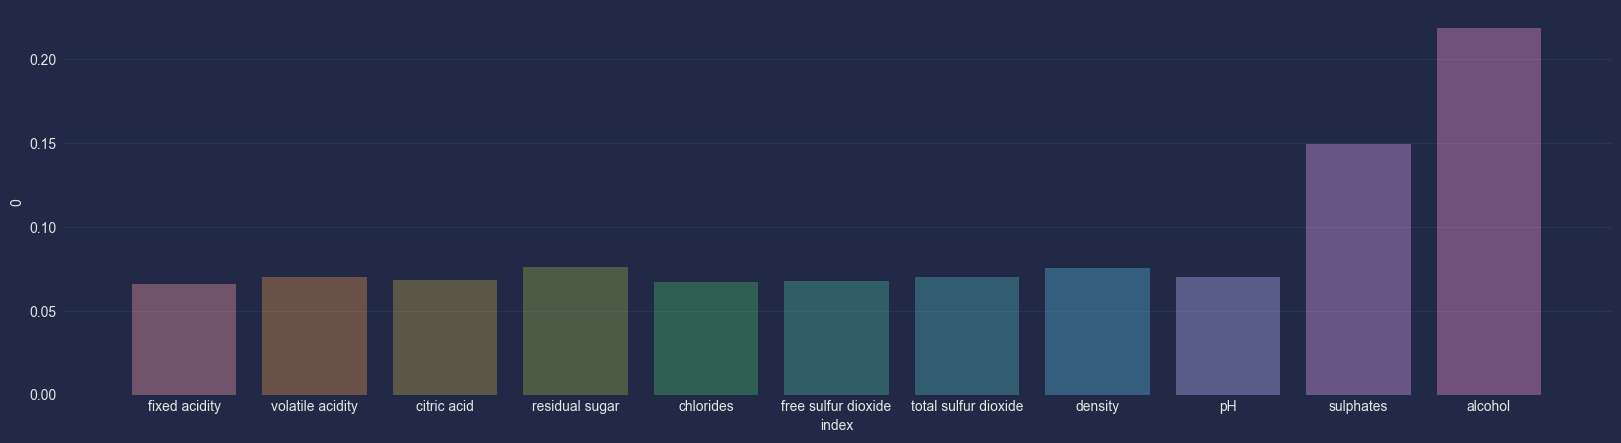

In [66]:
render_xgb_features(model)

In [98]:
train_df[f'xgb_first_{target[0]}'] = predictions
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0], f'xgb_first_{target[0]}'], boarders=True)

Error in callback <function _draw_all_if_interactive at 0x00000209FA73BB50> (for post_execute):


TypeError: must be real number, not str

TypeError: must be real number, not str

<Figure size 1600x900 with 34 Axes>

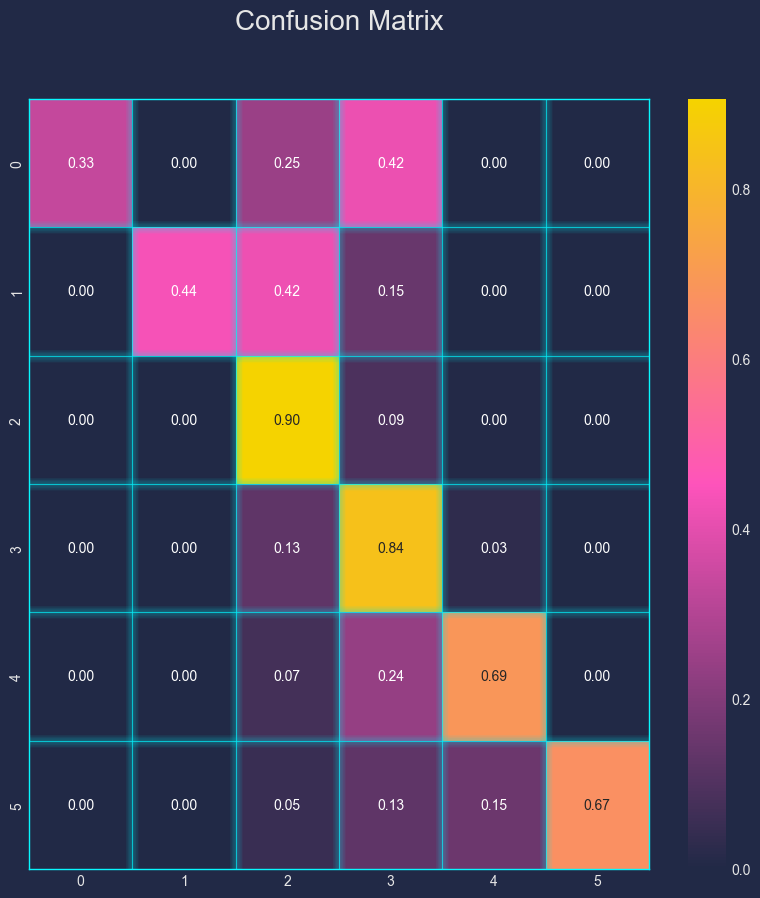

In [68]:
cm = confusion_matrix(train_df[target], predictions, normalize='true')
render_cm(cm)

In [69]:
train_final_preds = model.predict(train_df[features])+3
test_final_preds = model.predict(test_df[features])+3

In [70]:
train_submission = pd.DataFrame(data={'id': train_df.index, target[0]: train_final_preds})
train_submission.to_csv(fr'rendered_data/{objective}_train_submission.csv', index=False)

test_submission = pd.DataFrame(data={'id': test_df.index, target[0]: test_final_preds})
test_submission.to_csv(fr'rendered_data/{objective}_test_submission.csv', index=False)

In [53]:
param_test1 = {
 'max_depth':range(3,10,2),
 'min_child_weight':range(1,6,2)
}

gsearch1 = GridSearchCV(estimator = xgb.XGBClassifier(**static_params), param_grid = param_test1, cv=5, verbose=10)

X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)

gsearch1.fit(X_train, y_train, eval_set=[(X_valid, y_valid)])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START max_depth=3, min_child_weight=1............................
[0]	validation_0-mlogloss:1.51501
[1]	validation_0-mlogloss:1.37385
[2]	validation_0-mlogloss:1.28353
[3]	validation_0-mlogloss:1.21966
[4]	validation_0-mlogloss:1.17900
[5]	validation_0-mlogloss:1.14677
[6]	validation_0-mlogloss:1.12173
[7]	validation_0-mlogloss:1.10362
[8]	validation_0-mlogloss:1.09221
[9]	validation_0-mlogloss:1.08361
[10]	validation_0-mlogloss:1.07793
[11]	validation_0-mlogloss:1.07108
[12]	validation_0-mlogloss:1.06851
[13]	validation_0-mlogloss:1.06628
[14]	validation_0-mlogloss:1.06683
[15]	validation_0-mlogloss:1.06587
[16]	validation_0-mlogloss:1.06499
[17]	validation_0-mlogloss:1.06425
[18]	validation_0-mlogloss:1.06279
[19]	validation_0-mlogloss:1.06536
[20]	validation_0-mlogloss:1.06481
[21]	validation_0-mlogloss:1.06664
[22]	validation_0-mlogloss:1.06765
[23]	validation_0-mlogloss:1.06985
[24]	validation_0-mlogloss:1

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=100,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=3,
                                     max_leaves=None, min_child_weight=1,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None,
                                     objective='multi:softmax', predictor=None, ...),
             param_grid={'max_depth': range(3, 10, 2),
                         'min_child_weight': range(1, 6, 2)},
             verbose=10)

In [54]:
gsearch1.best_params_

{'max_depth': 3, 'min_child_weight': 3}

In [31]:
gsearch1.best_params_

{'max_depth': 3, 'min_child_weight': 1}

In [55]:
gsearch1.best_score_

0.5900492994291644

In [56]:
gsearch1.__dict__

{'scoring': None,
 'estimator': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, early_stopping_rounds=100,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=3, max_leaves=None,
               min_child_weight=1, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=-1, num_parallel_tree=None,
               objective='multi:softmax', predictor=None, ...),
 'n_jobs': None,
 'refit': True,
 'cv': 5,
 'verbose': 10,
 'pre_dispatch': '2*n_jobs',
 'error_score': nan,
 'return_train_score': False,
 'param_grid': {'max_depth': range(3, 10, 2),
  'min_child_weight':

In [62]:
predictions = gsearch1.best_estimator_.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions)
print(score)

0.451009982441284


In [57]:

static_params.update(gsearch1.best_params_)
print(f'tringing with:{static_params}')
eval_model = xgb.XGBClassifier(**static_params)
X_train, X_valid, y_train, y_valid = train_test_split(X, train_df[target], test_size=0.20)
eval_model.fit(X_train, y_train, eval_set=[(X_valid, y_valid)], verbose=False)
predictions = eval_model.predict(train_df[features])
score = cohen_kappa_score(train_df[target], predictions)
print(score)

tringing with:{'tree_method': 'gpu_hist', 'objective': 'multi:softmax', 'seed': 2016, 'n_jobs': -1, 'early_stopping_rounds': 100, 'max_depth': 3, 'min_child_weight': 3}
0.4623913728710849


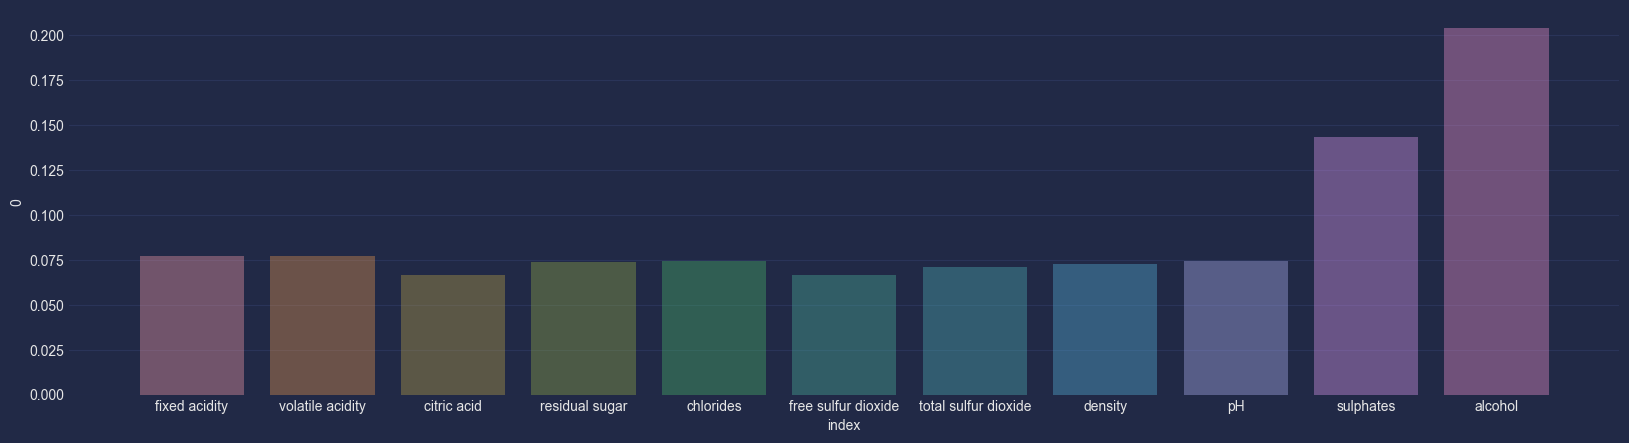

In [49]:
render_xgb_features(model)

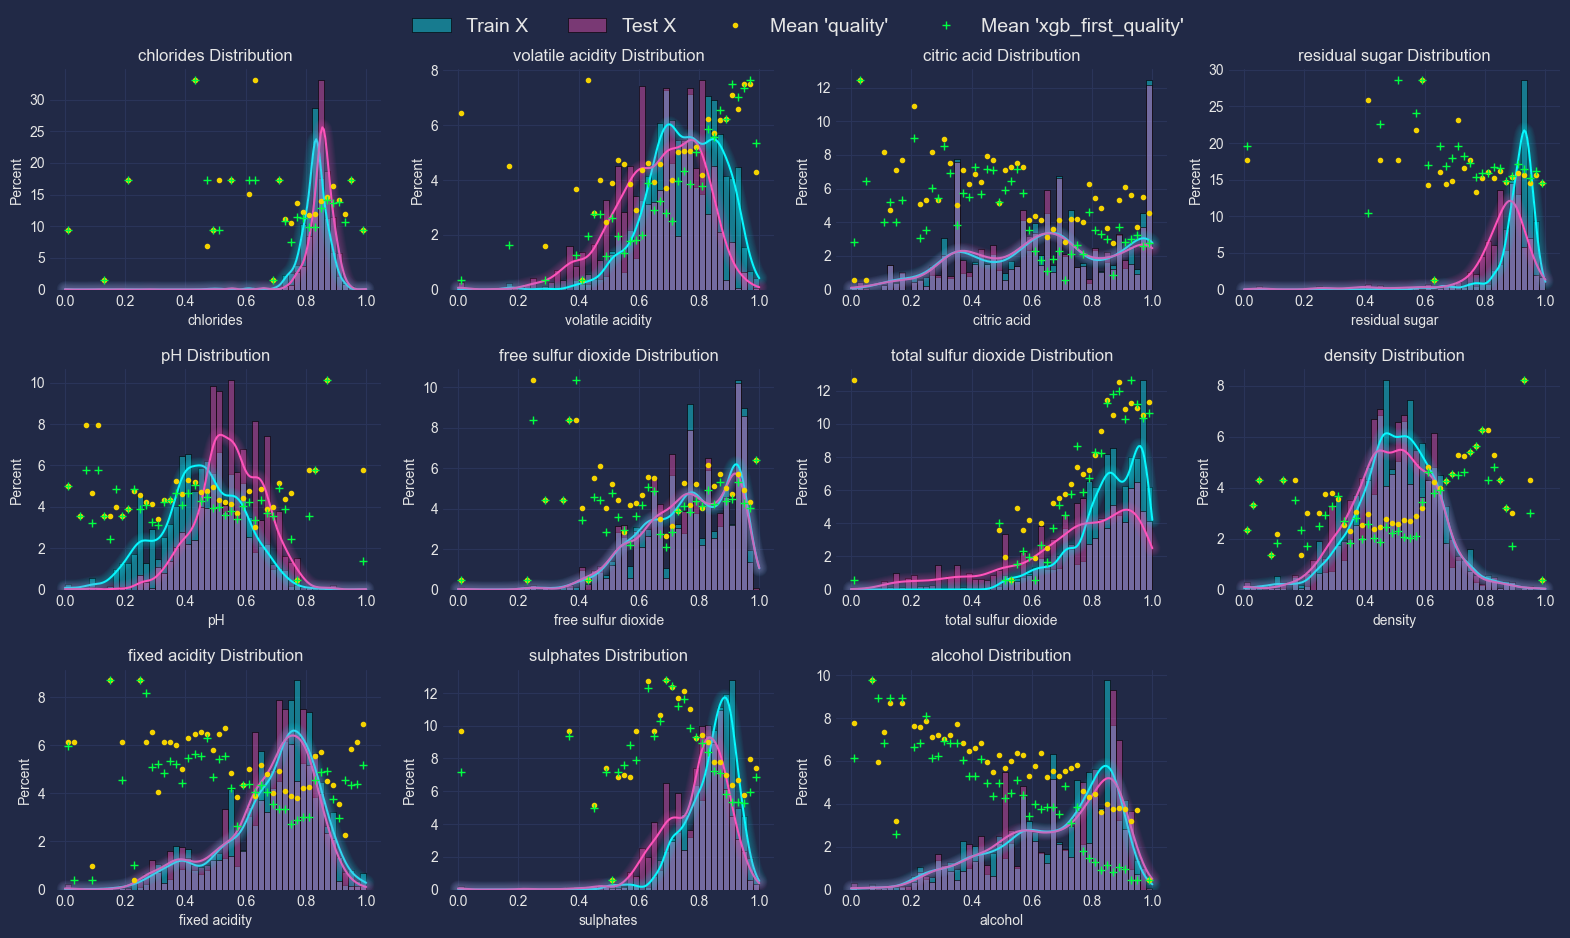

In [50]:
train_df[f'xgb_first_{target[0]}'] = predictions
render_feature_distros(train_df=train_df, test_df=test_df, features=features, labels=[target[0], f'xgb_first_{target[0]}'])

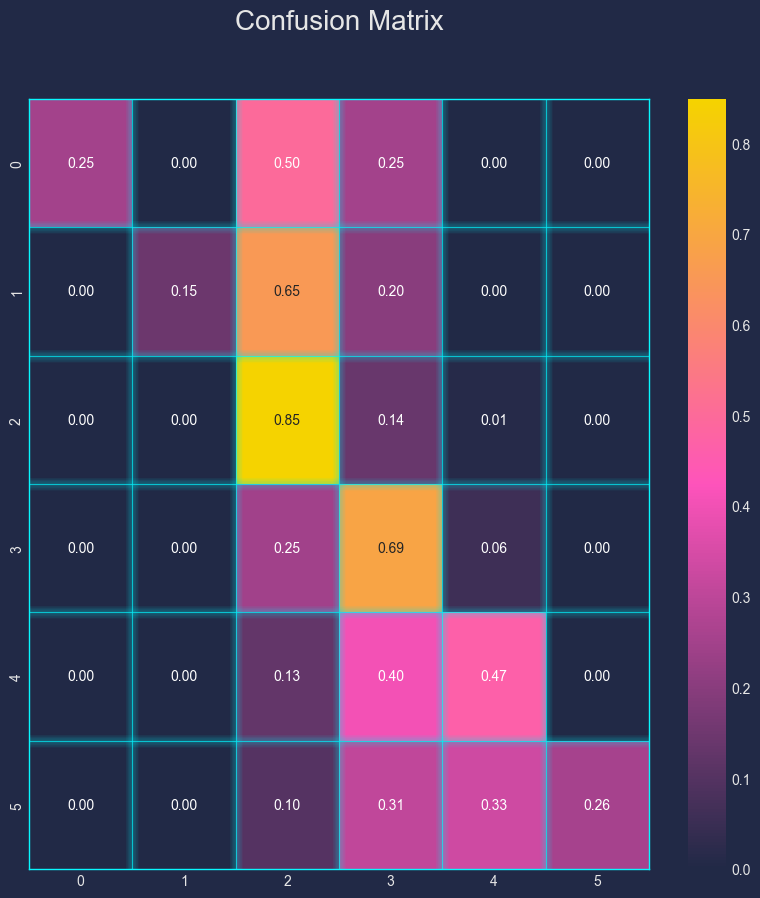

In [52]:
cm = confusion_matrix(train_df[target], predictions, normalize='true')
render_cm(cm)